In [4]:
#Import libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load dataset from CSV file
raw_data = pd.read_csv('ab_test_click_data.csv')
df = raw_data.copy()
# Display first 10 rows to understand data structure
df.head(10)

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00
5,6,0,exp,2024-01-01 00:05:00
6,7,1,exp,2024-01-01 00:06:00
7,8,1,exp,2024-01-01 00:07:00
8,9,0,exp,2024-01-01 00:08:00
9,10,0,exp,2024-01-01 00:09:00


In [6]:
# Check data types, missing values, and basic statistics
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    20000 non-null  int64 
 1   click      20000 non-null  int64 
 2   group      20000 non-null  object
 3   timestamp  10000 non-null  object
dtypes: int64(2), object(2)
memory usage: 625.1+ KB


,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [7]:
# Calculate total clicks per group
df.groupby('group').sum('click')

,user_id,click
group,,
con,150005000,1989
exp,50005000,6116


 A simple barchart showing the total clicks vs no clicks in each group can provide a clear visual comparison of user management

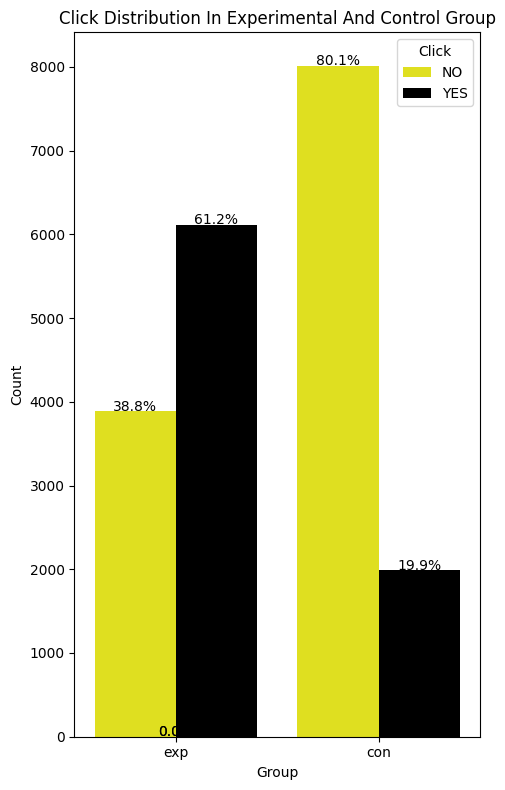

In [8]:
# Custom palette for visualization
palette = {0: 'Yellow', 1: 'black'}  # 0 = no-click, 1 = click

# Create figure
plt.figure(figsize=(5, 8))
ax = sns.countplot(x='group', hue='click', data=df, palette=palette)
plt.title('Click Distribution In Experimental And Control Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['NO', 'YES'])

# Calculate and annotate percentages
group_count = df.groupby(['group']).size()
for p in ax.patches:
    height = p.get_height()
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_count.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width()/2., height + 5, 
            f'{percentage:.1f}%', 
            ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

## Determining the statistics significance (alpha) and the power of the analysis (delta)

In [9]:
alpha = 0.05  # Significance level (5% probability of Type I error)
delta = 0.1   # Minimum Detectable Effect (MDE) for practical significance
print(f'Alpha significance level: {alpha}')
print(f'Delta (MDE): {delta}')


Alpha significance level: 0.05
Delta (MDE): 0.1


## Calculating the total number of clicks by group

In [10]:
# User counts per group
n_exp = df[df['group'] == 'exp'].shape[0]
n_con = df[df['group'] == 'con'].shape[0]

# Click counts per group
x_exp = df[df['group'] == 'exp']['click'].sum()
x_con = df[df['group'] == 'con']['click'].sum()

print(f'Experimental Group: {x_exp} clicks out of {n_exp} users')
print(f'Control Group: {x_con} clicks out of {n_con} users')

# Click probabilities
p_exp_hat = x_exp / n_exp
p_con_hat = x_con / n_con
print(f'Experimental Group Click Rate: {p_exp_hat:.4f}')
print(f'Control Group Click Rate: {p_con_hat:.4f}')

# Pooled probability
p_pooled_hat = (x_exp + x_con) / (n_exp + n_con)
print(f'Pooled Click Probability: {p_pooled_hat:.4f}')

Experimental Group: 6116 clicks out of 10000 users
Control Group: 1989 clicks out of 10000 users
Experimental Group Click Rate: 0.6116
Control Group Click Rate: 0.1989
Pooled Click Probability: 0.4052


# Hypothesis testing setup

In [11]:
# Pooled variance calculation
pooled_variance = p_pooled_hat * (1 - p_pooled_hat) * (1/n_exp + 1/n_con)

# Standard error
SE = np.sqrt(pooled_variance)
print(f'Pooled Variance: {pooled_variance:.6f}')
print(f'Standard Error: {SE:.6f}')

# Z-test statistic
test_stat = (p_exp_hat - p_con_hat) / SE
print(f'Test Statistic (Z-score): {test_stat:.4f}')

# Critical value (two-tailed test)
z_crit = norm.ppf(1 - alpha/2)
print(f'Critical Z-value: ±{z_crit:.4f}')

Pooled Variance: 0.000048
Standard Error: 0.006943
Test Statistic (Z-score): 59.4416
Critical Z-value: ±1.9600


## Calculate p-value and determine statistical significance

In [13]:
# Two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(test_stat)))
print(f'P-value: {p_value:.10f}')

# Statistical significance determination
if p_value < alpha:
    print('Result: Statistically Significant (reject H0)')
    print('Evidence suggests different click rates between groups')
else:
    print('Result: Not Statistically Significant (fail to reject H0)')
    print('No evidence of different click rates between groups')

P-value: 0.0000000000
Result: Statistically Significant (reject H0)
Evidence suggests different click rates between groups


## Confidence interval calculation

In [14]:
# Difference in proportions
diff = p_exp_hat - p_con_hat

# 95% Confidence Interval
CI_lower = diff - z_crit * SE
CI_upper = diff + z_crit * SE
print(f'95% Confidence Interval: ({CI_lower:.4f}, {CI_upper:.4f})')

95% Confidence Interval: (0.3991, 0.4263)


as seen the range of the confidence interval is narrow 0.3991 and 0.4263. the narrow our confidence interval the higher our accuracy. this essentially means that the result we are getting based on our small sample will most likely general as well when we deploy the model to a larger poplulation. it means the result is most likely for the general population.

when ever we have a primary metric that is in form of averages like we are using the p_exp_hat and the p_con_hat. then form already dictates that we use either **perimetric test** correspondign to this averages or **non perimetric test** corresponding to this averages

## Practical significance assessment

In [15]:
# Check if confidence interval exceeds MDE
if CI_lower > delta or CI_upper < -delta:
    print('Result: Practically Significant')
    print(f'The difference exceeds our MDE threshold of {delta}')
else:
    print('Result: Not Practically Significant')
    print(f'The difference is smaller than our MDE threshold of {delta}')

Result: Practically Significant
The difference exceeds our MDE threshold of 0.1


# Visualize Gaussian distribution with rejection regions

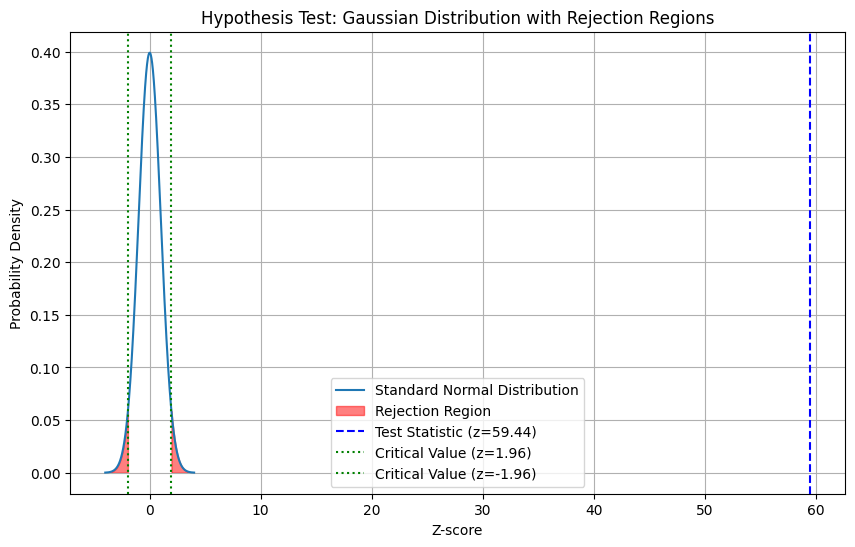

In [16]:
plt.figure(figsize=(10, 6))

# Create x values
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x)

# Plot distribution
plt.plot(x, y, label='Standard Normal Distribution')

# Fill rejection regions (two-tailed test)
fill_x_left = np.linspace(-4, -z_crit, 100)
fill_x_right = np.linspace(z_crit, 4, 100)
plt.fill_between(fill_x_left, norm.pdf(fill_x_left), color='red', alpha=0.5, label='Rejection Region')
plt.fill_between(fill_x_right, norm.pdf(fill_x_right), color='red', alpha=0.5)

# Add test statistic
plt.axvline(test_stat, color='blue', linestyle='--', label=f'Test Statistic (z={test_stat:.2f})')

# Add critical values
plt.axvline(z_crit, color='green', linestyle=':', label=f'Critical Value (z={z_crit:.2f})')
plt.axvline(-z_crit, color='green', linestyle=':', label=f'Critical Value (z={-z_crit:.2f})')

# Labels and title
plt.title('Hypothesis Test: Gaussian Distribution with Rejection Regions')
plt.xlabel('Z-score')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

## Visualize confidence interval

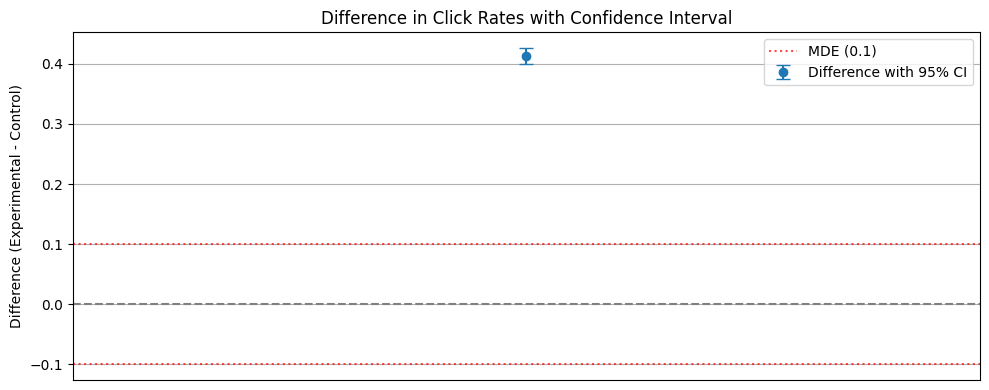

In [17]:
plt.figure(figsize=(10, 4))

# Point estimate and CI
plt.errorbar(x=0, y=diff, 
             yerr=[[diff - CI_lower], [CI_upper - diff]], 
             fmt='o', 
             capsize=5,
             label='Difference with 95% CI')

# Reference lines
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=delta, color='red', linestyle=':', alpha=0.7, label=f'MDE ({delta})')
plt.axhline(y=-delta, color='red', linestyle=':', alpha=0.7)

# Labels and title
plt.title('Difference in Click Rates with Confidence Interval')
plt.ylabel('Difference (Experimental - Control)')
plt.xticks([])  # Hide x-axis
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing for practical Significance of the Test

In [23]:
def is_practically_significant(delta, CI_95):
    """
    We asses here if the diffrence between control and experimental group is practically using the minimun deteactable effect (MDE)  
    
    Arguements:
    - delta (float): The minimum Detactable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% confidence interval.

    Returns:
    - Prints wether the experiment has practical significance based on the MDE CI.
    
    """

    # Extract lower bound of 95% confidence interval
    lower_bound_CI = CI_95[0]

    # check if the lower bound of the CI is greater than or equal to delta
    if lower_bound_CI >= delta:
        print(f'We have practical significance! \nwith MDE of {delta}, The diffrence between control and Experimental group is practically significant.')
        return True
    else:
        print('We don\'t have practical! \nThe difference between control and Experimental group is not practically significant.')

 

In [24]:
CI_95 = (CI_lower, CI_upper)
significance = is_practically_significant(delta, CI_95)
print(f'lower bound of 95% interval is: {CI_95[0]}')

We have practical significance! 
with MDE of 0.1, The diffrence between control and Experimental group is practically significant.
lower bound of 95% interval is: 0.3990920775390248
